# Allen Church: Dropbox Data Science Take Home Assessment
## May 25, 2022
### Customer Experience Team

In [1]:
# Data wrangling and viz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Neural net
from keras.models import Sequential
from keras.layers import Dense

## 1. Patterns Associated with Low-Scoring Tickets

### Data cleaning and ingestion

In [2]:
# Filter out missing SURVEY_SCORE since this is the variable of interest, drop columns
df = pd.read_csv('/Users/allenchurch/Downloads/ca_takehome_assessment.csv')

df = df.dropna(subset=['SURVEY_SCORE']).reset_index(drop=True).drop(
    columns=['ticket_id','CREATED_DAY','CLOSED_DAY','CREATED_TIME']).reset_index(drop=True)

# Convert column to int and dropna for user_type and ticket replies
df['SURVEY_SCORE'] = df['SURVEY_SCORE'].astype(int)
df = df.dropna(subset=['user_type','TICKET_REPLIES'])

# Fill other support channels with 0 for call_length_min and chat_duration otherwise these get dropped
df[['CALL_LENGTH_MIN','CHAT_DURATION_MIN','FULL_RESOLUTION_TIME']] = df[['CALL_LENGTH_MIN','CHAT_DURATION_MIN','FULL_RESOLUTION_TIME']].fillna(0)

df = df[(df['CALL_LENGTH_MIN'] >= 0) & (df['CALL_LENGTH_MIN'] < 100000) ]

# Remove ISSUE_TYPE_CATEGORY 'agent do not use' since this looks like an internal label for unusable data
df = df[df['ISSUE_TYPE_CATEGORY'] != 'agent do not use'].reset_index(drop=True)

# Create binary variable representing a high score
df['high_score'] = np.where((df['SURVEY_SCORE'] == 4) | (df['SURVEY_SCORE'] == 5),1, 0)

df.head()

,SUPPORT_CHANNEL,user_type,COUNTRY,ISSUE_TYPE_CATEGORY,TICKET_REPLIES,CALL_LENGTH_MIN,CHAT_DURATION_MIN,FULL_RESOLUTION_TIME,SURVEY_SCORE,high_score
0,chat,business,jp,desktop app,1.0,0.0,12.716667,4.766667,5,1
1,chat,business,jp,admin console,2.0,0.0,31.116667,37.700000,4,1
2,chat,business,es,payments,1.0,0.0,21.250000,0.283333,5,1
3,chat,business,jp,restorations,1.0,0.0,8.166667,1.916667,5,1
4,chat,business,se,admin console,1.0,0.0,8.166667,4.283333,5,1


### Random Forest Classifier to reveal feature importance

In [3]:
# Select target variable
y = df['high_score']


# One hot encode categorical variables
X = pd.get_dummies(df,
               columns=['SUPPORT_CHANNEL','user_type','COUNTRY','ISSUE_TYPE_CATEGORY']
                   ).drop(
    columns=['SURVEY_SCORE', 'high_score'])

### `FULL_RESOLUTION_TIME`,  `CHAT_DURATION_MIN`, and `TICKET_REPLIES` are associated with high-scoring tickets
<br>
Select a random forest classifier since it makes no assumptions about the underlying distribution of the data. Also, since random forest is an ensemble method, we can leverage multiple decision trees to calculate feature importance.

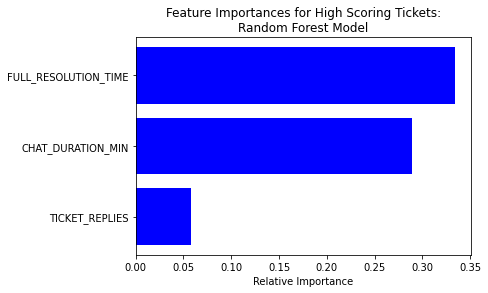

In [4]:
# Select a random forest classifier
forest=RandomForestClassifier()
forest.fit(X, y)

features = X.columns
importances = forest.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 3

#plt.figure(figsize=(10,100))
plt.title('Feature Importances for High Scoring Tickets:'
         "\n"
         'Random Forest Model')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [5]:
# Only use the top 3 input variables and print coefficients
X1 = X[['FULL_RESOLUTION_TIME','CHAT_DURATION_MIN','TICKET_REPLIES']]

# Fit linear model for coefficients
linreg = LinearRegression()
linreg.fit(X1, y)
linreg.coef_

pd.DataFrame(linreg.coef_, 
             X1.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False).round(3)

,coef
TICKET_REPLIES,0.011
CHAT_DURATION_MIN,-0.001
FULL_RESOLUTION_TIME,-0.001


### Email support channel has an average resolution time of 3x other channels

Text(0.5, 1.0, 'Average Resolution Time per Support Channel')

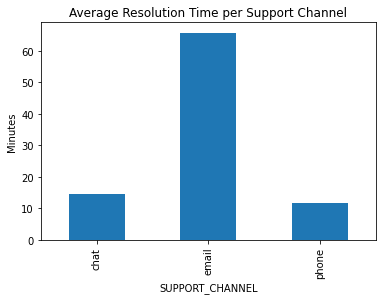

In [6]:
df.groupby('SUPPORT_CHANNEL')['FULL_RESOLUTION_TIME'].mean().plot(kind = "bar")
plt.ylabel('Minutes')
plt.title('Average Resolution Time per Support Channel')

## 2. Business Recommendations

Based on the above analysis, I recommend focusing on three aspects of the customer support journey:

1. **Email support interactions**: The average email support resolution time was over 3 times greater than chat or phone, leading to lower customer satisfication on surveys. This could imply a resource shortage for this support channel.

2. **Chat support satisfaction**: Longer support chats are associated with decreased customer satisfaction. Although chat and phone resolution time are roughly equal, I recommend looking into surveys on chat support. We could use NLP methods such as topic modeling to reveal common themes in this customer journey.

3. **Ticket replies**: Ticket replies was the only positively associated value with higher satisfaction. It would be interesting to examine the length between ticket replies, and whether this also increases satisfaction.

## 3. Predictive Modeling

**Feature Selection**: Using the Random Forest Classifier above, I use the top 3 variables (`FULL_RESOLUTION_TIME`,`CHAT_DURATION_MIN`,`TICKET_REPLIES`) as input for the below models to predict high survey scores. Focusing on predictive power, I fit a series of models and evaluate their performances using 10- fold cross validation.
<br>

**Model Selection**: After evaluating LogisticRegression, LinearDiscriminantAnalysis, KNeighborsClassifier, DecisionTreeClassifier, GaussianNB, SVC, and Keras Neural Network classifiers, I choose the SVC due to its raw accuracy score. After using GridSearch to find optimal hyperparameters, it did not significantly out-perform the default hyperparameters.
<br>

**Model Performance**: Using 10-fold cross validation, I assess model performance with the mean of these reuslts. I use a classification result (compiled from a confusion matrix) to check the specific SVC classifier performance. Precision reveals that the SVC model identified positive predictions 89% of the time. Recall reveals the model correctly identified all positive instances of high survey scores.

<AxesSubplot:>

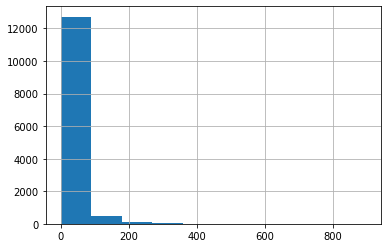

In [7]:
X.FULL_RESOLUTION_TIME.hist()

<AxesSubplot:>

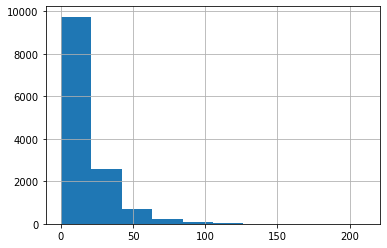

In [8]:
X.CHAT_DURATION_MIN.hist()

<AxesSubplot:>

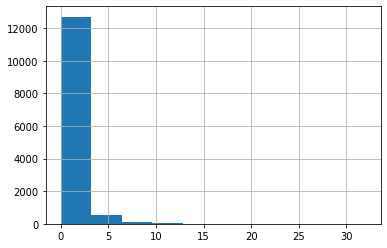

In [9]:
X.TICKET_REPLIES.hist()

In [10]:
# Normalize features since they do not have Gaussian distribution
X_subset = X[['FULL_RESOLUTION_TIME','CHAT_DURATION_MIN', 'TICKET_REPLIES']]
# create scaler
scaler = MinMaxScaler()
# fit and transform in one step
normalized_X = scaler.fit_transform(X_subset)

In [11]:
# splitting training vs. testing data
X_train, X_test, y_train, y_test = train_test_split(
                        normalized_X, y,
                test_size = 0.30, random_state = 101)

### Fitting 6 popular classifiers and plotting model performance

LR: 0.885387 (0.009730)
LDA: 0.881328 (0.010056)
KNN: 0.873637 (0.013033)
CART: 0.815850 (0.014080)
NB: 0.858257 (0.009186)
SVM: 0.886669 (0.010968)


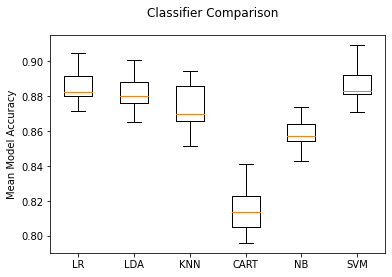

In [12]:
# initialize classifiers
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# plot classifier comparison
fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel('Mean Model Accuracy')
plt.show()

### Fitting a neural network to compare against previous classifiers

In [13]:
model = Sequential()
# 3 input variables for input_dim
model.add(Dense(12, input_dim=3, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Loss function is binary_crossentropy for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=15, batch_size=10, verbose=2)


Epoch 1/15
937/937 - 2s - loss: 0.3903 - accuracy: 0.8851 - 2s/epoch - 2ms/step
Epoch 2/15
937/937 - 1s - loss: 0.3464 - accuracy: 0.8859 - 1s/epoch - 1ms/step
Epoch 3/15
937/937 - 1s - loss: 0.3425 - accuracy: 0.8857 - 1s/epoch - 1ms/step
Epoch 4/15
937/937 - 1s - loss: 0.3404 - accuracy: 0.8855 - 1s/epoch - 1ms/step
Epoch 5/15
937/937 - 1s - loss: 0.3396 - accuracy: 0.8852 - 1s/epoch - 1ms/step
Epoch 6/15
937/937 - 1s - loss: 0.3390 - accuracy: 0.8856 - 1s/epoch - 1ms/step
Epoch 7/15
937/937 - 1s - loss: 0.3386 - accuracy: 0.8853 - 1s/epoch - 1ms/step
Epoch 8/15
937/937 - 1s - loss: 0.3377 - accuracy: 0.8854 - 1s/epoch - 1ms/step
Epoch 9/15
937/937 - 1s - loss: 0.3372 - accuracy: 0.8855 - 1s/epoch - 1ms/step
Epoch 10/15
937/937 - 1s - loss: 0.3368 - accuracy: 0.8859 - 1s/epoch - 1ms/step
Epoch 11/15
937/937 - 1s - loss: 0.3364 - accuracy: 0.8857 - 1s/epoch - 1ms/step
Epoch 12/15
937/937 - 1s - loss: 0.3360 - accuracy: 0.8859 - 1s/epoch - 1ms/step
Epoch 13/15
937/937 - 1s - loss: 0.33

### Choosing final model and assessing performance

In [14]:

model = SVC()
model.fit(X_train, y_train)
 
# print prediction results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.40      0.01      0.02       434
           1       0.89      1.00      0.94      3579

    accuracy                           0.89      4013
   macro avg       0.65      0.50      0.48      4013
weighted avg       0.84      0.89      0.84      4013



## 4. Data Cleaning for questions 1-3
<br>
Data cleaning included:
**Question 1:**

- Dropping columns (`ticket_id`, `CREATED_DAY`,`CLOSED_DAY`,`CREATED_TIME`) since these did not reveal much about the underlying data trends.
- Assessing missing data per variable. As seen in the visualization below, `SURVEY_SCORE`, `CALL_LENGTH_MIN`, and `CHAT_DURATION_MIN` had relatively high missing values. I dropped the missing `SURVEY_SCORE`, since that was the target variable, and filled the missing `CALL_LENGTH_MIN` and `CHAT_DURATION_MIN` with 0's since dropping these values entirely would remove all other support channels. 
- Dropped `CALL_LENGTH_MIN` rows with negative numbers or $100,000$ min as this looked like an error.
- Dropped `ISSUE_TYPE_CATEGORY` with value 'agent do not use' as this looked like an internal label for unusable data.

**Question 2:**
- Normalizing input variables `FULL_RESOLUTION_TIME`,`CHAT_DURATION_MIN`, `TICKET_REPLIES` since they did not have a Gaussian distribution. Failure to normalize these input variables would have affected the accuracy of our classifiers.

<Figure size 720x432 with 0 Axes>

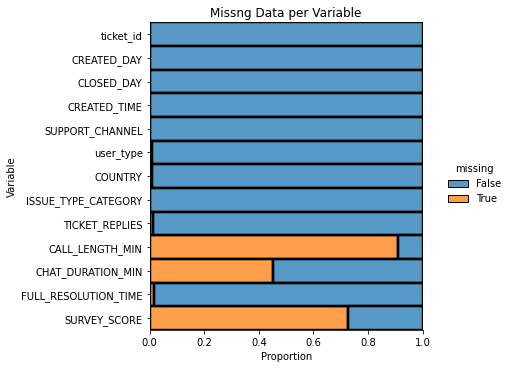

In [15]:
df_original = pd.read_csv('/Users/allenchurch/Downloads/ca_takehome_assessment.csv')

# Visualize missing values across variables
plt.figure(figsize=(10,6))
sns.displot(
    data=df_original.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
).set(
    xlabel='Proportion', ylabel='Variable', title='Missng Data per Variable'
)

## 5. Ideas for Follow Up:

The following data points and metrics would be interesting to try given more time and data, focusing on customer-specific vs. support specific aspects. How do the following variables interact with quality of customer support:


**Customer Specific**
- Length of time as customer
- Returning customer
- Active customer, if not, date of attrition    
- Customer Health Metric: how often do they use Dropbox?
- Qualitative/survey feedback: NLP sentinment analysis and topic modeling

**Support Specific**
- First contact resolution rate: % of tickets resolved after first contact
- Time spent waiting for support
- Number of unique interactions with customer support
- Is this a re-opened support ticket?
- Size of customer organization (if applicable)
- Call center agent ID and location ID for micro and macro level support trends